# Trabajo práctico Nº 5 

## Ejercicio 2 

Se implementa el mismo sistema de comunicación simplificado que en el ejercicio anterior aunque de una forma más ligada a la implementación en **hardware**. Para así poder generar los archivos de vectores, probar en varios puntos la señal, etc. 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tool.ff_model  as fm
from tool._fixedInt import * 
from tool.DSPtools import *

* Creamos una función para guardar los valores de los vectores generados para utilizarlos en vector matching

In [53]:
def SaveBytesTbFile(FpValues,FileName,BITs=1):
    TbFile  = open(FileName,'w')
    if(not BITs):
        for FpNum in FpValues:
            TbBin =bin(FpNum.intvalue)[2:]      #"0b" no me interesa 
            TbBin = TbBin.zfill(FpNum.width)    #Aveces bin() devuelve menos bits
            TbBin = str(TbBin)
            TbFile.write(TbBin)
            TbFile.write("\n")
        TbFile.close()
    else: 
        for i in range(len(FpValues)):
            TbFile.write(str(FpValues[i]))
            TbFile.write("\n")
        TbFile.close() 
    

Definimos los mismos parámetros que para el ejercicio anterior, agregando algunos extras, como el **orden de PSBR** a implementar emulando una LSFR 

In [2]:
clk = 100e6                 #Clock Freq.  
N = 4                       #Oversampling 
BR = clk / N                #Baud Rate 
rolloff = 0.5               
fs = N*BR                   #Sample Freq. 
Ts = 1/fs                   #Sample T. 
T = 1/BR                    #Symbol sep 
M = 2                       #Symbols (levels) 
Nsymb = 1e3                 #Simulation Length 
NB = 6                      #RC taps
PRBSn = 9                   #PRBS order

### 1) Generamos Pseudo Random Bit Sequence 

Modelo de implementación con LFSR 
![LFSR](./imgs/lfsr.png)

**NOTA**: Se agrega una pequeña modificación al módulo ff para que pueda recibir enteros en cualquier base (decimal, hexa, bin) y cargue la representación en bits a cada uno de los ff 

```
binList = [1 if digit=='1' else 0 for digit in bin(lfsrISeed)[2:]] 
```

In [3]:
lfsrI = fm.ff(PRBSn)
lfsrQ = fm.ff(PRBSn)
#lfsrISeed=np.array([1,1,0,1,0,1,0,1,0])
#lfsrQSeed=np.array([1,1,1,1,1,1,1,1,0])
lfsrISeed=0x1AA           
lfsrQSeed=0x1FE            

#Secuencia creada a partir de la LFSR 
PRBSeqI= []
PRBSeqQ= []

In [4]:
#LFSR siguiendo el modelo de ejemplo 
lfsrI.i = lfsrISeed
lfsrQ.i = lfsrQSeed
lfsrI.run_clock()
lfsrQ.run_clock()

for clkPulse in range(int(Nsymb)):
    lfsrI[0].i =  lfsrI[4].o ^ lfsrI[8].o       #Suma - XOR 
    lfsrQ[0].i =  lfsrQ[4].o ^ lfsrQ[8].o       
    
    for p in range(1,PRBSn):                    #Desplazamiento
        lfsrI[p].i = lfsrI[p-1].o
        lfsrQ[p].i = lfsrQ[p-1].o
    
    lfsrI.run_clock()
    lfsrQ.run_clock()
    
    PRBSeqI.append(lfsrI[PRBSn-1].o)
    PRBSeqQ.append(lfsrQ[PRBSn-1].o)

In [54]:
print(PRBSeqI[:20])
print(PRBSeqQ[:20])
SaveBytesTbFile(PRBSeqI,"./vectors/PRBSeqI.in",1)
SaveBytesTbFile(PRBSeqQ,"./vectors/PRBSeqQ.in",1)

[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1]


### 2) Mapper 

Se creó una secuencia de **bits** aleatorios. Para convertir estos bits en símbolos, se implementa un bloque de mapeo, que convierte los bits 1 en +1 y los bits 0 en -1

In [6]:
akI = np.array(PRBSeqI)
akQ = np.array(PRBSeqQ)

akI[akI>0] = 1 
akI[akI<=0] = -1 
akQ[akQ>0]=1
akQ[akQ<=0]=-1

#Paso a Fixed Point aunque no tiene mucho sentido 
#porque no piero info al truncar 1 y -1 con 2 bits 

akIFp =  arrayFixedInt(2,0, akI,'S', 
    roundMode='trunc', saturateMode='saturate')
akQFp =  arrayFixedInt(2,0, akQ,'S', 
    roundMode='trunc', saturateMode='saturate')


In [55]:
SaveBytesTbFile(akI,"./vectors/aKI.in",1)
SaveBytesTbFile(akQ,"./vectors/aKQ.in",1)

### 3) Upsampler 

Lo hago solo para comparar. Al hacer el filtro de pulse shaping con transformación polifásica no necesito upsamplear antes 

In [7]:
def upsampler(symb,N): 
    symb_up = np.zeros(N*len(symb),dtype=int)
    symb_up[: :N] = [Fp.fValue for Fp in symb]                    #Cada N igualo a symb
    return  symb_up

In [8]:
akIup = upsampler(akIFp,N)
akQup = upsampler(akQFp,N)

 * Comprobamos que los símbolos se hayan creado y sobremuestreado correctamente 

In [9]:
print(akI[:4])
print(akQ[:4])
print(akIup[:4*N])
print(akQup[:4*N])

[ 1 -1  1 -1]
[1 1 1 1]
[ 1  0  0  0 -1  0  0  0  1  0  0  0 -1  0  0  0]
[1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]


 * Graficamos histogramas para lo símbolos aleatorios

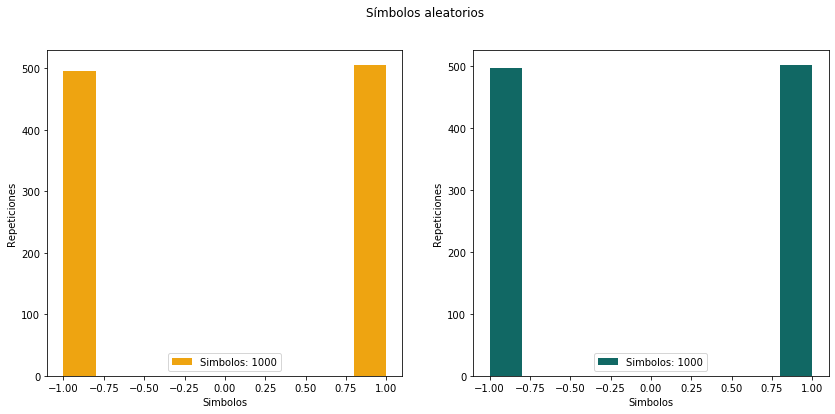

In [10]:
plt.figure(figsize=[14,6])
plt.suptitle("Símbolos aleatorios")
plt.subplot(1,2,1)
plt.hist(akI,label='Simbolos: %d' % Nsymb,color='#EEA411')
plt.legend()
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.subplot(1,2,2)
plt.hist(akQ,label='Simbolos: %d' % Nsymb,color='#116864')
plt.legend()
plt.xlabel('Simbolos')
plt.ylabel('Repeticiones')
plt.show()

### 4) Pulse shaping 

In [11]:
(t,h) = rcosine(rolloff,T,N,NB,Norm=False)
#Cuantizo 
Fp = arrayFixedInt(8,7, h,'S', 
    roundMode='round', saturateMode='saturate')
hFp = [FixedPintValue.fValue for FixedPintValue in Fp]


* Respuesta en frecuencia de filtro **cuantizado** 

Text(0, 0.5, 'Amplitud')

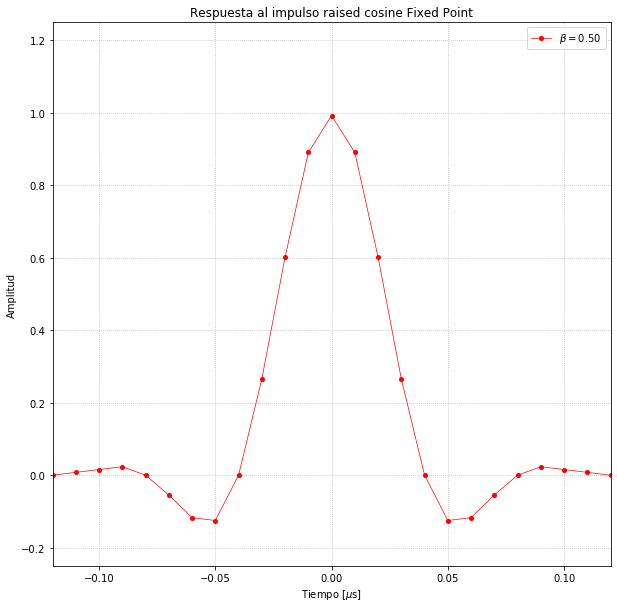

In [12]:
us = 1e6
plt.figure(figsize = [10,10])
plt.grid(linestyle=':', linewidth=0.75)
plt.plot(t*us,hFp,'r-o',linewidth = 0.7,
         markersize=4,label=r'$\beta=%2.2f$'%rolloff)

plt.title ('Respuesta al impulso raised cosine Fixed Point')
plt.legend()
plt.xlim(t[0]*us,t[-1]*us)
plt.ylim(-0.25,1.25)
plt.xlabel('Tiempo [$\mu$s]')
plt.ylabel('Amplitud')

* Respuesta en frecuencia 

In [13]:
NFTT = 1024 
[H,A,F] = resp_freq(hFp, Ts, NFTT)
H_dB = 20*np.log10(H)- 20*np.log10(H[0])

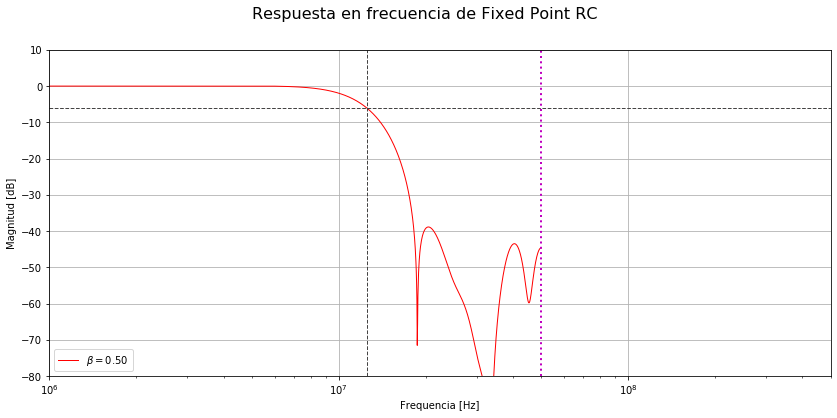

In [14]:
fig=plt.figure(figsize=[14,6])
fig.suptitle('Respuesta en frecuencia de Fixed Point RC ', fontsize=16)

plt.semilogx(F,H_dB ,'r', lw=1.0, label=r'$\beta=%2.2f$'%rolloff)

plt.axvline(x=(1./Ts)/2.,color='m',linewidth=2.0,
           linestyle=":")
plt.axvline(x=(1./T)/2.,color='#454444',
            linewidth=1,linestyle="--") 
plt.axhline(y=20*np.log10(0.5),color='#454444',
            linewidth=1,linestyle="--")

plt.legend(loc=3)
plt.grid(True)
plt.xlim(10e5,F[-1]*10)
plt.ylim(-80,10)
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.show()

* Realizamos la convolución tratando de simular la implementación en hardware

![FIR filter](./imgs/FIRFilter.png)

En vez de implementar el filtro de la figura se puede aplicar una **transformación polifásica**, dividir la señal en las 4 fases (N=4) y así lograr un hardware de 4 veces menor longitud y así más simple de implementar. 

La longitud de cada filtro será N x NBaudiosRC / N 

In [15]:
(t,h) = rcosine(rolloff,T,N,NB,Norm=False)
txSymbISoft = np.convolve(hFp,akIup,'same')   

#### Implemetanción filtro con transformación polifásica

In [16]:
lFilt = int( (len(h)-1) / N)             #Longitud de Filtro por fase 

txSymbI = []                   #Salida In Phase - Simbolos convolucionados
txSymbQ = []                   #Salida In Quadrature 

ConvRegI = fm.ff(lFilt)                   #Reg para convolucion
ConvRegQ = fm.ff(lFilt)                   #Reg para convolucion de SymbQ 


In [17]:
k=-1
for validPulse in range(int(Nsymb)): 
    k=k+1
    #Seq input - Uso directamente la PRBSeq mapeada a Baud Rate (sin Os)
    ConvRegI[0].i = akIFp[k].fValue
    ConvRegQ[0].i = akQFp[k].fValue
    #Shift register a Baud Rate 
    for z in range(1,lFilt): 
        ConvRegI[z].i = ConvRegI[z-1].o 
        ConvRegQ[z].i = ConvRegQ[z-1].o 
      
    #Mux de coeficientes - fase de 1 a 4 
    #A frecuencia de clk (en 1 validPulse hago 4 mult)
   
    for clkPulse in range(N):
        SumI = 0
        SumQ = 0
        print("y[{}]".format(len(txSymbI)))
        for Reg in range(lFilt):
            numCoef = clkPulse +Reg*N
            SumI = SumI + (ConvRegI[Reg].o * hFp[numCoef])
            SumQ = SumQ + (ConvRegQ[Reg].o * hFp[numCoef])
            print("Término {} = ConvReg[{}] ({}) * hFp[{}] ({})".
               format(Reg,Reg,ConvRegI[Reg].o,numCoef,hFp[numCoef]))
       
        txSymbI.append(SumI) 
        txSymbQ.append(SumQ)
    
    #Nuevo pulso de clk/4  = Baud Rate 
    #Desplazamiento de registros 
    ConvRegI.run_clock()
    ConvRegQ.run_clock()
    print("------------Shift-----------")

y[0]
Término 0 = ConvReg[0] (0) * hFp[0] (0.0)
Término 1 = ConvReg[1] (0) * hFp[4] (0.0)
Término 2 = ConvReg[2] (0) * hFp[8] (0.0)
Término 3 = ConvReg[3] (0) * hFp[12] (0.9921875)
Término 4 = ConvReg[4] (0) * hFp[16] (0.0)
Término 5 = ConvReg[5] (0) * hFp[20] (0.0)
y[1]
Término 0 = ConvReg[0] (0) * hFp[1] (0.0078125)
Término 1 = ConvReg[1] (0) * hFp[5] (-0.0546875)
Término 2 = ConvReg[2] (0) * hFp[9] (0.265625)
Término 3 = ConvReg[3] (0) * hFp[13] (0.890625)
Término 4 = ConvReg[4] (0) * hFp[17] (-0.125)
Término 5 = ConvReg[5] (0) * hFp[21] (0.0234375)
y[2]
Término 0 = ConvReg[0] (0) * hFp[2] (0.015625)
Término 1 = ConvReg[1] (0) * hFp[6] (-0.1171875)
Término 2 = ConvReg[2] (0) * hFp[10] (0.6015625)
Término 3 = ConvReg[3] (0) * hFp[14] (0.6015625)
Término 4 = ConvReg[4] (0) * hFp[18] (-0.1171875)
Término 5 = ConvReg[5] (0) * hFp[22] (0.015625)
y[3]
Término 0 = ConvReg[0] (0) * hFp[3] (0.0234375)
Término 1 = ConvReg[1] (0) * hFp[7] (-0.125)
Término 2 = ConvReg[2] (0) * hFp[11] (0.890625)

Término 1 = ConvReg[1] (1.0) * hFp[5] (-0.0546875)
Término 2 = ConvReg[2] (-1.0) * hFp[9] (0.265625)
Término 3 = ConvReg[3] (-1.0) * hFp[13] (0.890625)
Término 4 = ConvReg[4] (1.0) * hFp[17] (-0.125)
Término 5 = ConvReg[5] (1.0) * hFp[21] (0.0234375)
y[398]
Término 0 = ConvReg[0] (1.0) * hFp[2] (0.015625)
Término 1 = ConvReg[1] (1.0) * hFp[6] (-0.1171875)
Término 2 = ConvReg[2] (-1.0) * hFp[10] (0.6015625)
Término 3 = ConvReg[3] (-1.0) * hFp[14] (0.6015625)
Término 4 = ConvReg[4] (1.0) * hFp[18] (-0.1171875)
Término 5 = ConvReg[5] (1.0) * hFp[22] (0.015625)
y[399]
Término 0 = ConvReg[0] (1.0) * hFp[3] (0.0234375)
Término 1 = ConvReg[1] (1.0) * hFp[7] (-0.125)
Término 2 = ConvReg[2] (-1.0) * hFp[11] (0.890625)
Término 3 = ConvReg[3] (-1.0) * hFp[15] (0.265625)
Término 4 = ConvReg[4] (1.0) * hFp[19] (-0.0546875)
Término 5 = ConvReg[5] (1.0) * hFp[23] (0.0078125)
------------Shift-----------
y[400]
Término 0 = ConvReg[0] (-1.0) * hFp[0] (0.0)
Término 1 = ConvReg[1] (1.0) * hFp[4] (0.0)
Té

------------Shift-----------
y[880]
Término 0 = ConvReg[0] (1.0) * hFp[0] (0.0)
Término 1 = ConvReg[1] (1.0) * hFp[4] (0.0)
Término 2 = ConvReg[2] (1.0) * hFp[8] (0.0)
Término 3 = ConvReg[3] (1.0) * hFp[12] (0.9921875)
Término 4 = ConvReg[4] (-1.0) * hFp[16] (0.0)
Término 5 = ConvReg[5] (1.0) * hFp[20] (0.0)
y[881]
Término 0 = ConvReg[0] (1.0) * hFp[1] (0.0078125)
Término 1 = ConvReg[1] (1.0) * hFp[5] (-0.0546875)
Término 2 = ConvReg[2] (1.0) * hFp[9] (0.265625)
Término 3 = ConvReg[3] (1.0) * hFp[13] (0.890625)
Término 4 = ConvReg[4] (-1.0) * hFp[17] (-0.125)
Término 5 = ConvReg[5] (1.0) * hFp[21] (0.0234375)
y[882]
Término 0 = ConvReg[0] (1.0) * hFp[2] (0.015625)
Término 1 = ConvReg[1] (1.0) * hFp[6] (-0.1171875)
Término 2 = ConvReg[2] (1.0) * hFp[10] (0.6015625)
Término 3 = ConvReg[3] (1.0) * hFp[14] (0.6015625)
Término 4 = ConvReg[4] (-1.0) * hFp[18] (-0.1171875)
Término 5 = ConvReg[5] (1.0) * hFp[22] (0.015625)
y[883]
Término 0 = ConvReg[0] (1.0) * hFp[3] (0.0234375)
Término 1 = Co

Término 4 = ConvReg[4] (1.0) * hFp[19] (-0.0546875)
Término 5 = ConvReg[5] (1.0) * hFp[23] (0.0078125)
------------Shift-----------
y[1432]
Término 0 = ConvReg[0] (1.0) * hFp[0] (0.0)
Término 1 = ConvReg[1] (1.0) * hFp[4] (0.0)
Término 2 = ConvReg[2] (1.0) * hFp[8] (0.0)
Término 3 = ConvReg[3] (1.0) * hFp[12] (0.9921875)
Término 4 = ConvReg[4] (1.0) * hFp[16] (0.0)
Término 5 = ConvReg[5] (1.0) * hFp[20] (0.0)
y[1433]
Término 0 = ConvReg[0] (1.0) * hFp[1] (0.0078125)
Término 1 = ConvReg[1] (1.0) * hFp[5] (-0.0546875)
Término 2 = ConvReg[2] (1.0) * hFp[9] (0.265625)
Término 3 = ConvReg[3] (1.0) * hFp[13] (0.890625)
Término 4 = ConvReg[4] (1.0) * hFp[17] (-0.125)
Término 5 = ConvReg[5] (1.0) * hFp[21] (0.0234375)
y[1434]
Término 0 = ConvReg[0] (1.0) * hFp[2] (0.015625)
Término 1 = ConvReg[1] (1.0) * hFp[6] (-0.1171875)
Término 2 = ConvReg[2] (1.0) * hFp[10] (0.6015625)
Término 3 = ConvReg[3] (1.0) * hFp[14] (0.6015625)
Término 4 = ConvReg[4] (1.0) * hFp[18] (-0.1171875)
Término 5 = ConvRe

Término 1 = ConvReg[1] (-1.0) * hFp[6] (-0.1171875)
Término 2 = ConvReg[2] (1.0) * hFp[10] (0.6015625)
Término 3 = ConvReg[3] (-1.0) * hFp[14] (0.6015625)
Término 4 = ConvReg[4] (-1.0) * hFp[18] (-0.1171875)
Término 5 = ConvReg[5] (-1.0) * hFp[22] (0.015625)
y[1915]
Término 0 = ConvReg[0] (-1.0) * hFp[3] (0.0234375)
Término 1 = ConvReg[1] (-1.0) * hFp[7] (-0.125)
Término 2 = ConvReg[2] (1.0) * hFp[11] (0.890625)
Término 3 = ConvReg[3] (-1.0) * hFp[15] (0.265625)
Término 4 = ConvReg[4] (-1.0) * hFp[19] (-0.0546875)
Término 5 = ConvReg[5] (-1.0) * hFp[23] (0.0078125)
------------Shift-----------
y[1916]
Término 0 = ConvReg[0] (-1.0) * hFp[0] (0.0)
Término 1 = ConvReg[1] (-1.0) * hFp[4] (0.0)
Término 2 = ConvReg[2] (-1.0) * hFp[8] (0.0)
Término 3 = ConvReg[3] (1.0) * hFp[12] (0.9921875)
Término 4 = ConvReg[4] (-1.0) * hFp[16] (0.0)
Término 5 = ConvReg[5] (-1.0) * hFp[20] (0.0)
y[1917]
Término 0 = ConvReg[0] (-1.0) * hFp[1] (0.0078125)
Término 1 = ConvReg[1] (-1.0) * hFp[5] (-0.0546875)
Té

y[2466]
Término 0 = ConvReg[0] (-1.0) * hFp[2] (0.015625)
Término 1 = ConvReg[1] (-1.0) * hFp[6] (-0.1171875)
Término 2 = ConvReg[2] (-1.0) * hFp[10] (0.6015625)
Término 3 = ConvReg[3] (-1.0) * hFp[14] (0.6015625)
Término 4 = ConvReg[4] (-1.0) * hFp[18] (-0.1171875)
Término 5 = ConvReg[5] (-1.0) * hFp[22] (0.015625)
y[2467]
Término 0 = ConvReg[0] (-1.0) * hFp[3] (0.0234375)
Término 1 = ConvReg[1] (-1.0) * hFp[7] (-0.125)
Término 2 = ConvReg[2] (-1.0) * hFp[11] (0.890625)
Término 3 = ConvReg[3] (-1.0) * hFp[15] (0.265625)
Término 4 = ConvReg[4] (-1.0) * hFp[19] (-0.0546875)
Término 5 = ConvReg[5] (-1.0) * hFp[23] (0.0078125)
------------Shift-----------
y[2468]
Término 0 = ConvReg[0] (-1.0) * hFp[0] (0.0)
Término 1 = ConvReg[1] (-1.0) * hFp[4] (0.0)
Término 2 = ConvReg[2] (-1.0) * hFp[8] (0.0)
Término 3 = ConvReg[3] (-1.0) * hFp[12] (0.9921875)
Término 4 = ConvReg[4] (-1.0) * hFp[16] (0.0)
Término 5 = ConvReg[5] (-1.0) * hFp[20] (0.0)
y[2469]
Término 0 = ConvReg[0] (-1.0) * hFp[1] (0.00

Término 3 = ConvReg[3] (1.0) * hFp[14] (0.6015625)
Término 4 = ConvReg[4] (-1.0) * hFp[18] (-0.1171875)
Término 5 = ConvReg[5] (1.0) * hFp[22] (0.015625)
y[3087]
Término 0 = ConvReg[0] (-1.0) * hFp[3] (0.0234375)
Término 1 = ConvReg[1] (1.0) * hFp[7] (-0.125)
Término 2 = ConvReg[2] (1.0) * hFp[11] (0.890625)
Término 3 = ConvReg[3] (1.0) * hFp[15] (0.265625)
Término 4 = ConvReg[4] (-1.0) * hFp[19] (-0.0546875)
Término 5 = ConvReg[5] (1.0) * hFp[23] (0.0078125)
------------Shift-----------
y[3088]
Término 0 = ConvReg[0] (-1.0) * hFp[0] (0.0)
Término 1 = ConvReg[1] (-1.0) * hFp[4] (0.0)
Término 2 = ConvReg[2] (1.0) * hFp[8] (0.0)
Término 3 = ConvReg[3] (1.0) * hFp[12] (0.9921875)
Término 4 = ConvReg[4] (1.0) * hFp[16] (0.0)
Término 5 = ConvReg[5] (-1.0) * hFp[20] (0.0)
y[3089]
Término 0 = ConvReg[0] (-1.0) * hFp[1] (0.0078125)
Término 1 = ConvReg[1] (-1.0) * hFp[5] (-0.0546875)
Término 2 = ConvReg[2] (1.0) * hFp[9] (0.265625)
Término 3 = ConvReg[3] (1.0) * hFp[13] (0.890625)
Término 4 = C

Término 1 = ConvReg[1] (-1.0) * hFp[6] (-0.1171875)
Término 2 = ConvReg[2] (-1.0) * hFp[10] (0.6015625)
Término 3 = ConvReg[3] (1.0) * hFp[14] (0.6015625)
Término 4 = ConvReg[4] (-1.0) * hFp[18] (-0.1171875)
Término 5 = ConvReg[5] (-1.0) * hFp[22] (0.015625)
y[3639]
Término 0 = ConvReg[0] (1.0) * hFp[3] (0.0234375)
Término 1 = ConvReg[1] (-1.0) * hFp[7] (-0.125)
Término 2 = ConvReg[2] (-1.0) * hFp[11] (0.890625)
Término 3 = ConvReg[3] (1.0) * hFp[15] (0.265625)
Término 4 = ConvReg[4] (-1.0) * hFp[19] (-0.0546875)
Término 5 = ConvReg[5] (-1.0) * hFp[23] (0.0078125)
------------Shift-----------
y[3640]
Término 0 = ConvReg[0] (-1.0) * hFp[0] (0.0)
Término 1 = ConvReg[1] (1.0) * hFp[4] (0.0)
Término 2 = ConvReg[2] (-1.0) * hFp[8] (0.0)
Término 3 = ConvReg[3] (-1.0) * hFp[12] (0.9921875)
Término 4 = ConvReg[4] (1.0) * hFp[16] (0.0)
Término 5 = ConvReg[5] (-1.0) * hFp[20] (0.0)
y[3641]
Término 0 = ConvReg[0] (-1.0) * hFp[1] (0.0078125)
Término 1 = ConvReg[1] (1.0) * hFp[5] (-0.0546875)
Térmi

* Convertimos los símbolos a la resolución del hardware Fixed point S(8,7) con truncado 

In [18]:
FpI = arrayFixedInt(8,7, txSymbI,'S', 
    roundMode='trunc', saturateMode='saturate')
txSymbIFp = [FixedPointValue.fValue for FixedPointValue in FpI]

FpQ = arrayFixedInt(8,7, txSymbQ,'S', 
    roundMode='trunc', saturateMode='saturate')
txSymbQFp = [FixedPointValue.fValue for FixedPointValue in FpQ]

* Graficamos la señal S(t) con resolución Fixed Point 

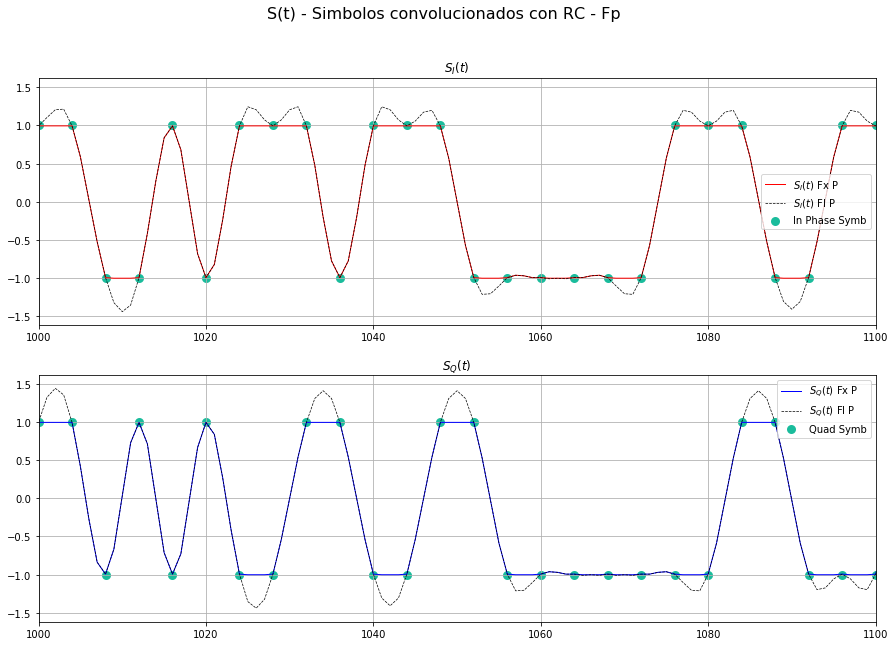

In [19]:

convDelay = int(len(hFp)/2) + N                        # + N por que es como upsamplear 

fig=plt.figure(figsize=[15,10])
fig.suptitle('S(t) - Simbolos convolucionados con RC - Fp', fontsize=16)

sp1= plt.subplot(2,1,1)
sp1.set_title("$S_I(t)$")
plt.plot(txSymbIFp,'r-',linewidth=1.0,label="$S_I(t)$ Fx P")
plt.plot(txSymbI,'k--',linewidth=.70,label="$S_I(t)$ Fl P")
plt.scatter([i + convDelay for i in np.where(akIup!=0)],akIup[akIup!=0],lw=3,
            label="In Phase Symb",color="#1abc9c")
plt.legend()
plt.xlim(1000,1100)
plt.grid(True)


sp2 = plt.subplot(2,1,2)
sp2.set_title("$S_Q(t)$")
plt.plot(txSymbQFp,'b-',linewidth=1.0,label="$S_Q(t)$ Fx P")
plt.plot(txSymbQ,'k--',linewidth=.70,label="$S_Q(t)$ Fl P")
plt.scatter([i + convDelay for i in np.where(akQup!=0)],akQup[akQup!=0],lw=3,
            label="Quad Symb",color="#1abc9c")
plt.legend()
plt.xlim(1000,1100)
plt.grid(True)


plt.show()

In [58]:
SaveBytesTbFile(FpI,"./vectors/txSymbIFp.in",0)
SaveBytesTbFile(FpQ,"./vectors/txSymbQFp.in",0)

* Diagrama de ojo de los símbolos transmitidos 

Text(0.5, 1.0, 'Quadrature')

<Figure size 1152x1152 with 0 Axes>

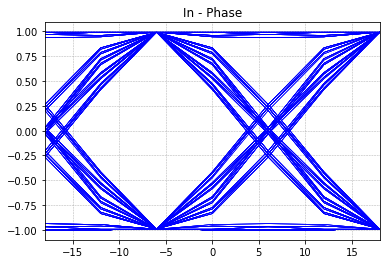

<Figure size 1152x1152 with 0 Axes>

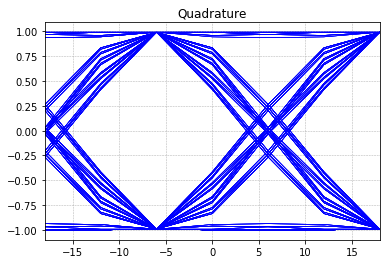

In [20]:
fig=plt.figure(figsize=[16,16])
guard=200
P=1
eyediagram(txSymbIFp[guard:-guard],N,P,NB)
plt.grid(linestyle='--', linewidth=0.5)
plt.title ('In - Phase')

fig=plt.figure(figsize=[16,16])
guard=200
P=1
eyediagram(txSymbQFp[guard:-guard],N,P,NB)
plt.grid(linestyle='--', linewidth=0.5)
plt.title ('Quadrature')

* Constelación de símbolos transmitidos 

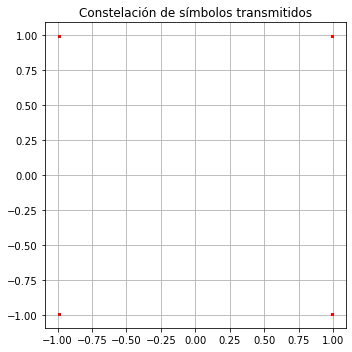

In [29]:
To=4
fig = plt.figure(figsize=[5,5])
                               
plt.plot(txSymbIFp[100+To:len(txSymbIFp)-(100-To):int(N)],                
        txSymbQFp[100+To:len(txSymbQFp)-(100-To):int(N)],                     
        '.r',lw=2.0,markersize=3)
plt.grid()
plt.title("Constelación de símbolos transmitidos")
plt.tight_layout()

### 5) Downsampler 

In [22]:
def DownSampler(symbUp,N,To): 
    symb = np.zeros(len(symbUp), dtype = int)
    symb = symbUp[To: :int(N)] 
    return symb 

In [30]:
To=1
rkI = DownSampler(txSymbIFp,N,To)
rkQ = DownSampler(txSymbQFp,N,To)
print(len(rkI))

1000


### 6) Slicer 


In [31]:
akIhat = [(1 if value >=0 else -1) for value in rkI]
akQhat = [(1 if value >=0 else -1) for value in rkQ]

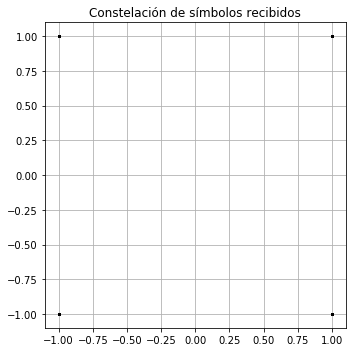

In [35]:
To=1
fig = plt.figure(figsize=[5,5])
                               
plt.plot(akIhat[100+To:len(akIhat)-(100-To):int(N)],                
        akQhat[100+To:len(akQhat)-(100-To):int(N)],                     
        '.k',lw=2.0,markersize=4)
plt.grid()
plt.title("Constelación de símbolos recibidos")
plt.tight_layout()

### 7) BER Checker 

In [36]:
ErrorI=0
ErrorQ=0

for i in range(int(Nsymb-1)):
    if akI[i]!=akIhat[i]:
        ErrorI=0
    if akQ[i]!=akQhat[i]:
        ErrorQ=0

        
SERI = ErrorI/Nsymb
SERQ = ErrorQ/Nsymb

#Calculo de BER de forma simple, aproximada
BERI = SERI * (1/np.log2(M))
BERQ = SERQ * (1/np.log2(M))


print("Bit Error Rate In Phase = ",BERI )
print("Bit Error Rate Quadrature = ",BERQ )

Bit Error Rate In Phase =  0.0
Bit Error Rate Quadrature =  0.0


Comprobamos que no hay error en el sistema de comunicación básico implementado, ya que no hay diferencia entre los bits transmitidos y recibidos, lo cual corresponde con que no se simule un canal que adicione ruido o cualquier otra fuente de ruido que afecte al a información. El **ruido de cuantización** tampoco afecta en la detección de símbolos en este caso 